# Summative Assessment 2

Romand Lansangan

Zion Ramilo

Jinghua Yang

---

## DATASET A: Fitting GARCH Model

### SPY Daily Returns (2015–2025)

Daily closing prices of the S&P 500 ETF (SPY) from Yahoo Finance. Log returns computed as `100 × Δlog(Close)`. ~2,500 observations capturing market volatility, trends, and crisis periods (e.g., COVID crash in 2020).

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd 

df_a = yf.download("SPY", start="2015-01-01", end="2025-12-10")
df_a = df_a.reset_index()

# Flatten multi-index columns
df_a.columns = df_a.columns.get_level_values(0)

df_a['Log_Return'] = 100 * np.log(df_a['Close']).diff()

df_a = df_a.reset_index()
df_a = df_a.dropna().drop(columns="index")


df_a.to_csv("spy_returns.csv", index=False)
df_a.head()

C:\Users\Romand\AppData\Local\Temp\ipykernel_17060\213236557.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_a = yf.download("SPY", start="2015-01-01", end="2025-12-10")
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume,Log_Return
1,2015-01-05,168.003769,170.210833,167.695616,170.044264,169632600,-1.822506
2,2015-01-06,166.421387,168.836665,165.621839,168.311962,209151400,-0.946337
3,2015-01-07,168.495209,168.836683,167.304230,167.753967,125346700,1.238427
4,2015-01-08,171.485077,171.701628,169.894331,169.910979,147217800,1.758893
5,2015-01-09,170.110916,171.918213,169.494598,171.901552,158567300,-0.804558


In [ ]:
df_a.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2750 entries, 1 to 2750
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        2750 non-null   datetime64[ns]
 1   Close       2750 non-null   float64       
 2   High        2750 non-null   float64       
 3   Low         2750 non-null   float64       
 4   Open        2750 non-null   float64       
 5   Volume      2750 non-null   int64         
 6   Log_Return  2750 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 171.9 KB


In [63]:
time_series_a = df_a[['Date', 'Log_Return']].set_index("Date").copy().squeeze()
time_series_a.head()


Date
2015-01-05   -1.822470
2015-01-06   -0.946346
2015-01-07    1.238400
2015-01-08    1.758938
2015-01-09   -0.804584
Name: Log_Return, dtype: float64

### Split

In [67]:
threshold = 0.80
upto = int(len(time_series_a)*0.80)
a_train = time_series_a.iloc[:upto]
a_test = time_series_a.iloc[upto:]
print("Train:", a_train.shape)
print("Test:", a_test.shape)

Train: (2200,)
Test: (550,)


### EDA

In [64]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_series(df, title, xlabel='index', ylabel='returns', rolling_windows=[30]):
    # Create figure with two subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    # Plot 1: Returns Series
    axes[0].plot(df.index, df[ylabel], color='blue', linewidth=0.8, alpha=0.7, label=ylabel)
    axes[0].axhline(y=0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
    axes[0].set_title(title, fontsize=14, fontweight='bold')
    axes[0].set_xlabel(xlabel, fontsize=11)
    axes[0].set_ylabel(ylabel, fontsize=11)
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()

    # Plot 2: Rolling Standard Deviations
    # Ensure rolling_windows is a list, even if a single integer is passed
    if not isinstance(rolling_windows, list):
        rolling_windows = [rolling_windows]

    for window in rolling_windows:
        rolling_std_name = f'rolling_std_{window}'
        df[rolling_std_name] = df[ylabel].rolling(window=window).std()
        axes[1].plot(df.index, df[rolling_std_name], linewidth=1.2, label=f'Window={window}')


    axes[1].set_title(f'Rolling Standard Deviation for various windows', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Index', fontsize=11)
    axes[1].set_ylabel('Standard Deviation', fontsize=11)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(title='Rolling Window Sizes') # Add a legend for different windows

    plt.tight_layout()
    plt.show()

    # ACF and PACF plots for squared returns
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    sq_ret = (df[ylabel].dropna().values)**2 # Drop NA if there are any from rolling calculations
    fig.suptitle(f'Autocorrelation and Partial Autocorrelation Functions of Squared ({ylabel.upper()})', fontsize=16, fontweight='bold')
    plot_acf(sq_ret, lags=20, ax=axes[0])
    plot_pacf(sq_ret, lags=20, ax=axes[1]);
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

In [71]:
a_train

Date
2015-01-05   -1.822470
2015-01-06   -0.946346
2015-01-07    1.238400
2015-01-08    1.758938
2015-01-09   -0.804584
                ...   
2023-09-25    0.419646
2023-09-26   -1.480019
2023-09-27    0.039900
2023-09-28    0.578056
2023-09-29   -0.242982
Name: Log_Return, Length: 2200, dtype: float64

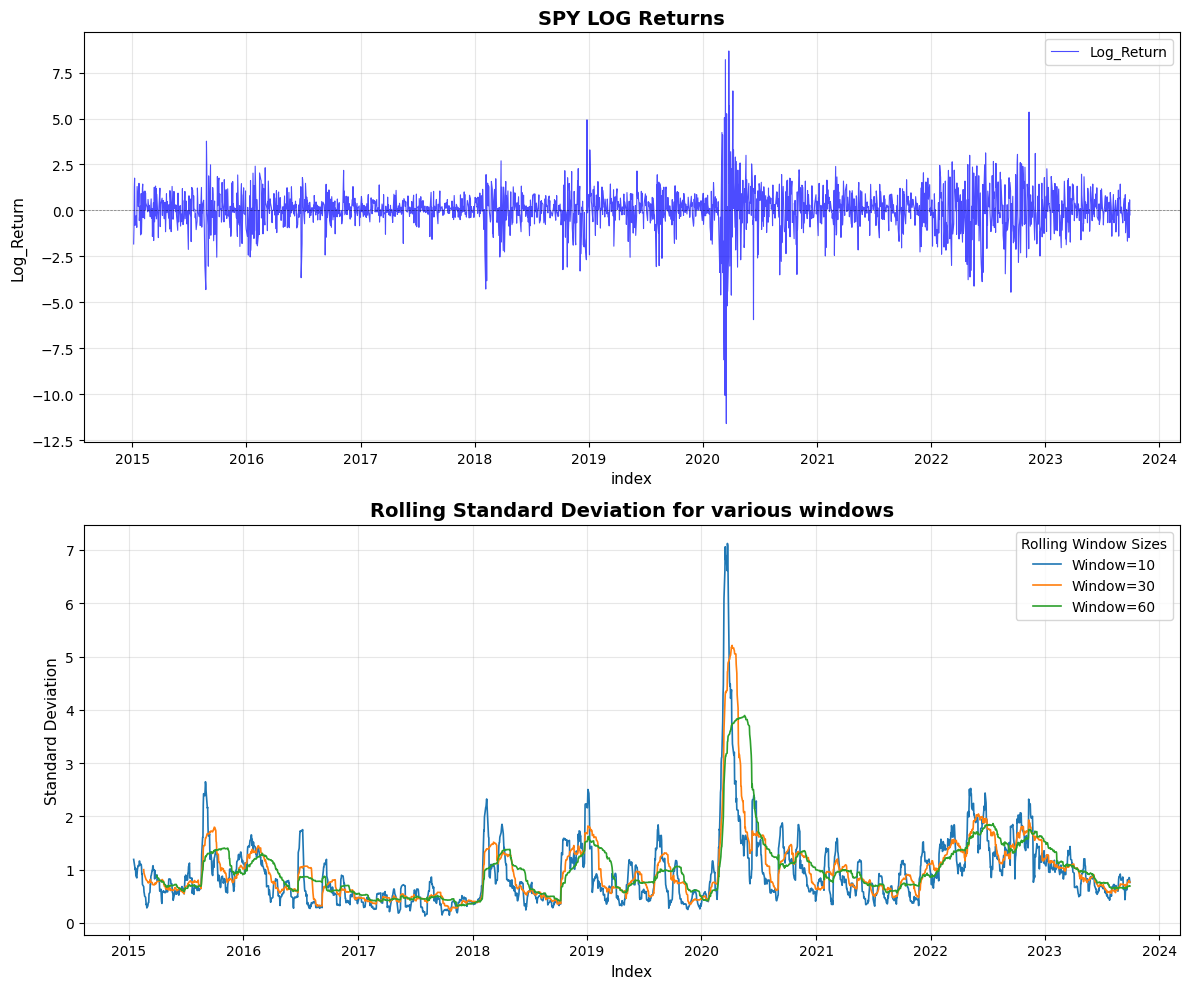

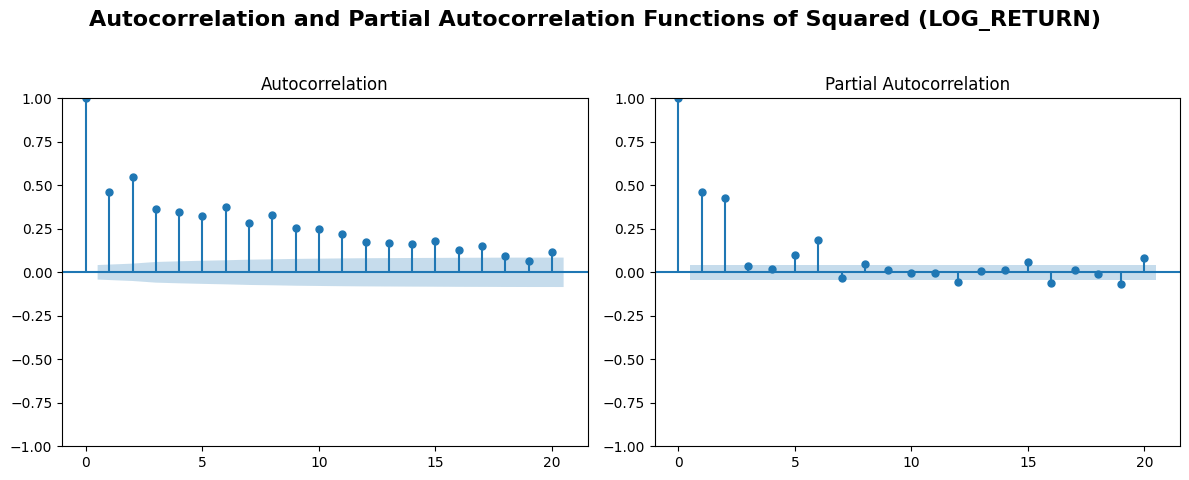

In [72]:

plot_series(a_train.to_frame(), title='SPY LOG Returns', rolling_windows=[10,30, 60], ylabel="Log_Return")

#### SPY Log Returns Series

The SPY Log Returns Series (top plot) shows returns fluctuating around 0 with clear volatility clustering. The most striking feature is the massive spike in early 2020 (COVID crash) with returns reaching -12% in a single day, followed by a +8% rebound. Large fluctuations are followed by large fluctuations—classic GARCH behavior.

The Rolling Standard Deviation (bottom plot) confirms time-varying volatility. All three windows (10, 30, 60) spike dramatically during the COVID period, with the 10-day window reaching ~7%. Other elevated periods include Aug 2015 (China devaluation), late 2018 (Fed tightening), and 2022 (inflation/rate hikes). This heteroskedasticity makes constant-variance models inappropriate.

#### ACF/PACF Analysis of Squared Returns

**ACF (left):** Slow, gradual decay from ~0.47 at lag 1, remaining significant through lag 20. This persistence indicates volatility shocks have long-lasting effects—today's high volatility predicts elevated volatility for many days ahead. Classic sign that a GARCH term (past conditional variance) is needed.

**PACF (right):** Sharp cutoff after lags 1-2 (~0.47 and ~0.42), with lag 5 showing a smaller spike (~0.2). The quick decay after lag 2 suggests the direct dependence on past squared shocks is concentrated in the first 1-2 lags.

#### Model Selection

| Pattern | Implication |
|---------|-------------|
| Slow ACF decay | Include GARCH term (p ≥ 1) |
| PACF cuts off at lag 1-2 | ARCH order q = 1 sufficient |

**Recommendation:** Start with **GARCH(1,1)**. The PACF lag-2 significance could justify testing GARCH(1,2) or GARCH(2,1), but GARCH(1,1) typically captures most dynamics parsimoniously.

Although for the sake of brevity, let us conduct rigorous gridsearch to test out different scenarious.

In [75]:
from arch import arch_model
import pandas as pd
import itertools

def garch_grid_search(returns, p_range=range(1,4), q_range=range(1,4), dist_list=['normal', 't']):
    """Grid search over GARCH(p,q) with different distributions"""
    results = {}
    
    for p, q, dist in itertools.product(p_range, q_range, dist_list):
        name = f"GARCH({p},{q})_{dist}"
        try:
            model = arch_model(returns, vol='Garch', p=p, q=q, dist=dist)
            fit = model.fit(disp='off')
            results[name] = {
                'model': fit,
                'aic': fit.aic,
                'bic': fit.bic,
                'loglik': fit.loglikelihood,
                'params': fit.params.to_dict()
            }
        except:
            results[name] = None
            
    # Summary table
    summary = pd.DataFrame({
        k: {'AIC': v['aic'], 'BIC': v['bic'], 'LogLik': v['loglik']} 
        for k, v in results.items() if v
    }).T.sort_values('BIC')
    
    return results, summary

In [78]:
models, summary = garch_grid_search(a_train)

print(summary)
print(f"\nBest by BIC: {summary.index[0]}")

                           AIC          BIC       LogLik
GARCH(1,1)_t       5564.683276  5593.164339 -2777.341638
GARCH(2,1)_t       5566.358176  5600.535451 -2777.179088
GARCH(1,2)_t       5566.683276  5600.860552 -2777.341638
GARCH(2,2)_t       5567.211490  5607.084979 -2776.605745
GARCH(3,1)_t       5568.358176  5608.231664 -2777.179088
GARCH(1,3)_t       5568.648760  5608.522249 -2777.324380
GARCH(2,3)_t       5569.160722  5614.730423 -2776.580361
GARCH(3,2)_t       5569.211490  5614.781191 -2776.605745
GARCH(3,3)_t       5571.558954  5622.824868 -2776.779477
GARCH(1,1)_normal  5704.154118  5726.938969 -2848.077059
GARCH(1,2)_normal  5706.145353  5734.626416 -2848.072676
GARCH(2,1)_normal  5706.154118  5734.635181 -2848.077059
GARCH(2,2)_normal  5707.632158  5741.809434 -2847.816079
GARCH(3,1)_normal  5708.088375  5742.265650 -2848.044187
GARCH(1,3)_normal  5708.145352  5742.322628 -2848.072676
GARCH(2,3)_normal  5709.118794  5748.992282 -2847.559397
GARCH(3,2)_normal  5710.055579 

### Error Diagnostic

In [79]:
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.gofplots import qqplot

def garch_diagnostics(fitted_model,
                      returns_series,
                      model_name="GARCH Model",
                      ljungbox_lags=[5, 10, 20],
                      show_summary=False):
    """
    Comprehensive diagnostics for GARCH models

    Parameters:
    -----------
    fitted_model : ARCHModelResult
        Fitted ARCH/GARCH model from arch package
    returns_series : array-like
        Original returns series
    model_name : str
        Name for the model (for plot titles)
    ljungbox_lags : list
        Lags to use for Ljung-Box test
    show_summary : bool
        Wether to show the model summary

    Returns:
    --------
    dict : Dictionary with all diagnostic test results
    """

    # Extract residuals
    std_resid = fitted_model.resid / fitted_model.conditional_volatility
    squared_std_resid = std_resid ** 2

    # Create figure with subplots
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    fig.suptitle(f'{model_name} Diagnostics', fontsize=14, fontweight='bold')

    # 1. Standardized Residuals Plot
    axes[0, 0].plot(std_resid, alpha=0.7)
    axes[0, 0].set_title('Standardized Residuals')
    axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[0, 0].set_xlabel('Time')

    # 2. Squared Standardized Residuals
    axes[0, 1].plot(squared_std_resid, alpha=0.7, color='orange')
    axes[0, 1].set_title('Squared Standardized Residuals')
    axes[0, 1].axhline(y=1, color='r', linestyle='--', alpha=0.5)
    axes[0, 1].set_xlabel('Time')

    # 3. Histogram of Standardized Residuals
    axes[0, 2].hist(std_resid, bins=30, density=True, alpha=0.7, color='green')
    xmin, xmax = axes[0, 2].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    axes[0, 2].plot(x, stats.norm.pdf(x, 0, 1), 'r-', label='Normal(0,1)')
    axes[0, 2].set_title('Distribution of Std Residuals')
    axes[0, 2].legend()

    # 4. QQ-Plot
    qqplot(std_resid, line='45', ax=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot')

    # 5. ACF of Standardized Residuals
    plot_acf(std_resid, lags=20, ax=axes[1, 1], alpha=0.05)
    axes[1, 1].set_title('ACF of Standardized Residuals')

    # 6. ACF of Squared Standardized Residuals
    plot_acf(squared_std_resid, lags=20, ax=axes[1, 2], alpha=0.05)
    axes[1, 2].set_title('ACF of Squared Std Residuals')

    # 7. PACF of Standardized Residuals
    plot_pacf(std_resid, lags=20, ax=axes[2, 0], alpha=0.05)
    axes[2, 0].set_title('PACF of Standardized Residuals')

    # 8. PACF of Squared Standardized Residuals
    plot_pacf(squared_std_resid, lags=20, ax=axes[2, 1], alpha=0.05)
    axes[2, 1].set_title('PACF of Squared Std Residuals')

    # 9. Conditional Volatility
    axes[2, 2].plot(fitted_model.conditional_volatility, color='purple', alpha=0.7)
    axes[2, 2].set_title('Conditional Volatility')
    axes[2, 2].set_xlabel('Time')

    plt.tight_layout()
    plt.show()

    # Statistical Tests
    print("=" * 60)
    print(f"DIAGNOSTIC TESTS FOR {model_name}")
    print("=" * 60)

    # 1. Model Information Criteria
    print("\n1. MODEL FIT CRITERIA:")
    print(f"   Log-Likelihood: {fitted_model.loglikelihood:.2f}")
    print(f"   AIC: {fitted_model.aic:.2f}")
    print(f"   BIC: {fitted_model.bic:.2f}")

    # 2. Ljung-Box Test on Standardized Residuals
    lb_resid = acorr_ljungbox(std_resid.dropna(), lags=ljungbox_lags, return_df=True)
    print("\n2. LJUNG-BOX TEST ON STANDARDIZED RESIDUALS:")
    print("   (H0: No serial correlation)")
    print(lb_resid[['lb_stat', 'lb_pvalue']].round(4))

    # 3. Ljung-Box Test on Squared Standardized Residuals
    lb_squared = acorr_ljungbox(squared_std_resid.dropna(), lags=ljungbox_lags, return_df=True)
    print("\n3. LJUNG-BOX TEST ON SQUARED STD RESIDUALS:")
    print("   (H0: No remaining ARCH effects)")
    print(lb_squared[['lb_stat', 'lb_pvalue']].round(4))

    # 4. ARCH-LM Test
    arch_lm = het_arch(std_resid.dropna(), nlags=5)
    print("\n4. ARCH-LM TEST:")
    print(f"   Statistic: {arch_lm[0]:.4f}")
    print(f"   P-value: {arch_lm[1]:.4f}")
    print(f"   Interpretation: {'No remaining ARCH effects ✓' if arch_lm[1] > 0.05 else 'ARCH effects remain ✗'}")

    # 5. Normality Tests
    jb_test = stats.jarque_bera(std_resid.dropna())
    shapiro_test = stats.shapiro(std_resid.dropna()[:5000] if len(std_resid) > 5000 else std_resid.dropna())

    print("\n5. NORMALITY TESTS:")
    print(f"   Jarque-Bera Statistic: {jb_test[0]:.4f}, P-value: {jb_test[1]:.4f}")
    print(f"   Shapiro-Wilk Statistic: {shapiro_test[0]:.4f}, P-value: {shapiro_test[1]:.4f}")
    print(f"   Interpretation: {'Residuals are normal ✓' if jb_test[1] > 0.05 else 'Residuals are non-normal ✗'}")

    # 6. Persistence (for GARCH models)
    if 'alpha[1]' in fitted_model.params and 'beta[1]' in fitted_model.params:
        persistence = fitted_model.params['alpha[1]'] + fitted_model.params['beta[1]']
        print(f"\n6. VOLATILITY PERSISTENCE (α + β): {persistence:.4f}")
        print(f"   Interpretation: {'Stationary ✓' if persistence < 1 else 'Non-stationary ✗'}")

    # 7. Model Summary
    if show_summary:
        print("\n7. MODEL SUMMARY:")
        print(fitted_model.summary())

    # Return results as dictionary for further use
    results = {
        'aic': fitted_model.aic,
        'bic': fitted_model.bic,
        'loglikelihood': fitted_model.loglikelihood,
        'ljung_box_resid': lb_resid['lb_pvalue'].values,
        'ljung_box_squared': lb_squared['lb_pvalue'].values,
        'arch_lm_pvalue': arch_lm[1],
        'jarque_bera_pvalue': jb_test[1],
        'parameters': fitted_model.params,
        'std_resid': std_resid
    }

    return results

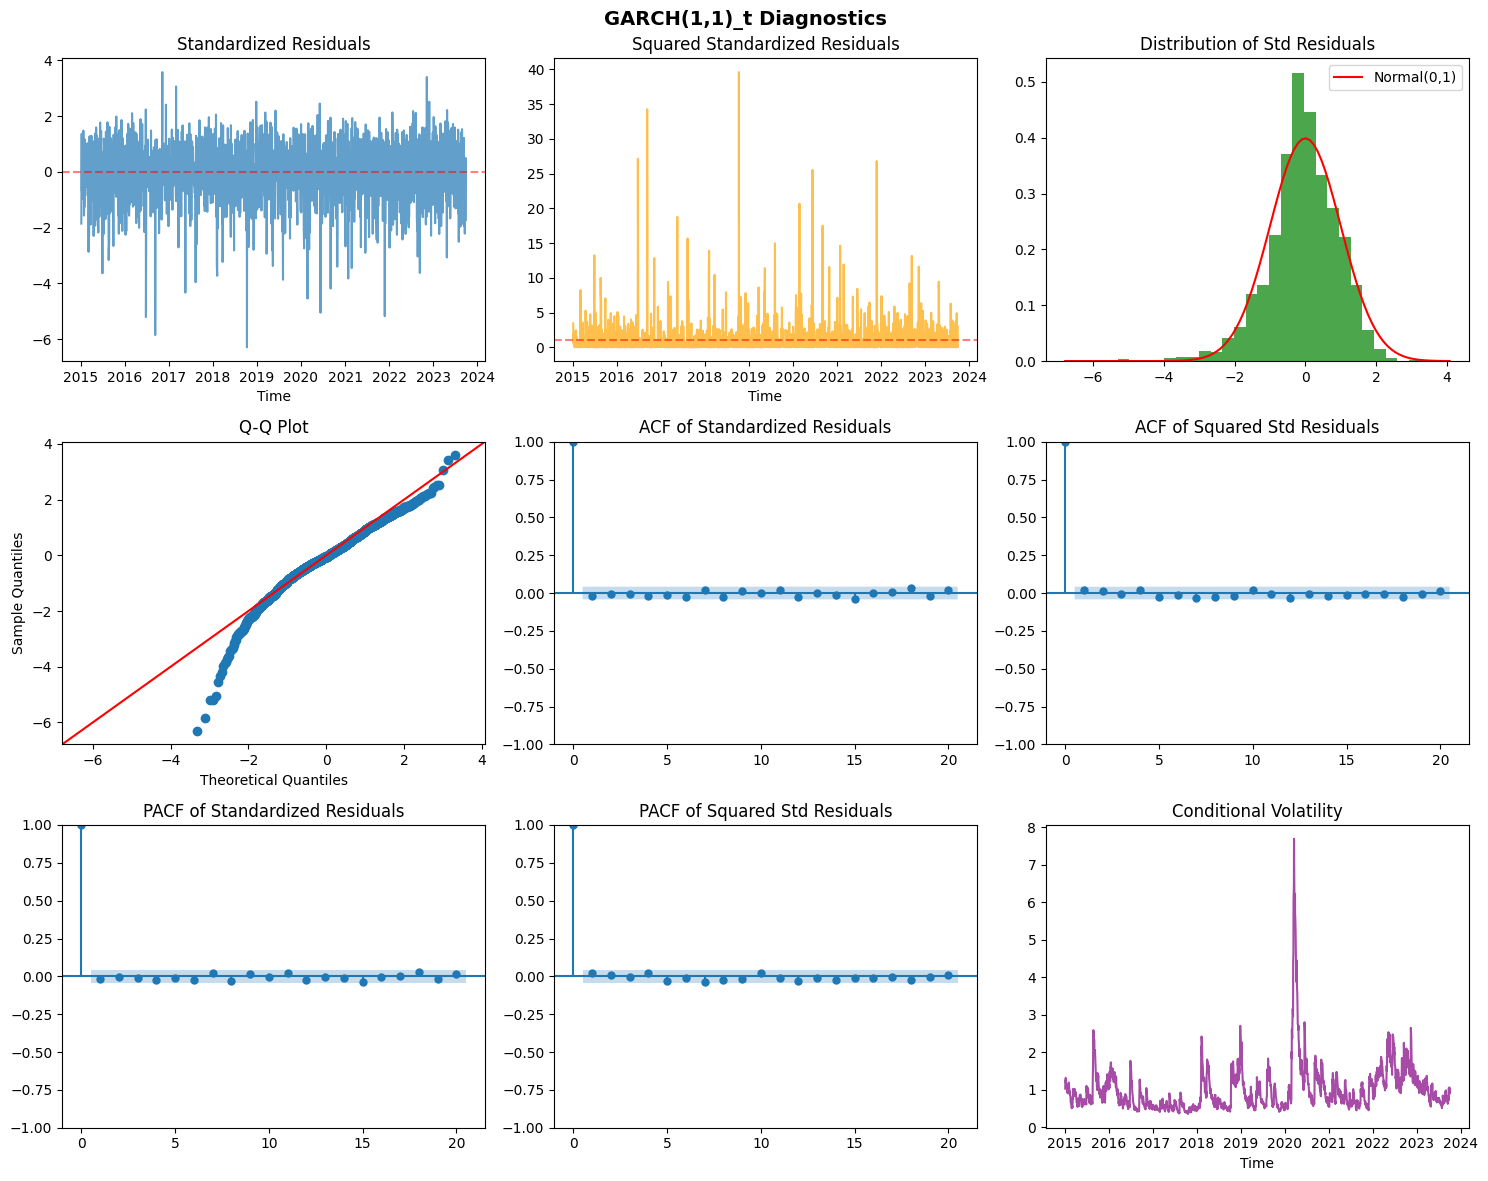

DIAGNOSTIC TESTS FOR GARCH(1,1)_t

1. MODEL FIT CRITERIA:
   Log-Likelihood: -2777.34
   AIC: 5564.68
   BIC: 5593.16

2. LJUNG-BOX TEST ON STANDARDIZED RESIDUALS:
   (H0: No serial correlation)
    lb_stat  lb_pvalue
5    2.1683     0.8254
10   6.8207     0.7423
20  16.5947     0.6791

3. LJUNG-BOX TEST ON SQUARED STD RESIDUALS:
   (H0: No remaining ARCH effects)
    lb_stat  lb_pvalue
5    3.9159     0.5616
10  10.7376     0.3783
20  15.7905     0.7295

4. ARCH-LM TEST:
   Statistic: 4.0260
   P-value: 0.5457
   Interpretation: No remaining ARCH effects ✓

5. NORMALITY TESTS:
   Jarque-Bera Statistic: 906.8592, P-value: 0.0000
   Shapiro-Wilk Statistic: 0.9662, P-value: 0.0000
   Interpretation: Residuals are non-normal ✗

6. VOLATILITY PERSISTENCE (α + β): 1.0000
   Interpretation: Stationary ✓


In [80]:
best = models[summary.index[0]]['model']

diag_10 = garch_diagnostics(best, a_train, "GARCH(1,1)_t")

#### GARCH(1,1) with Student-t: Diagnostic Summary

**Model Fit:** AIC=5564.68, BIC=5593.16

**Residual Autocorrelation:** Ljung-Box p-values > 0.67 across all lags. No serial correlation remains—mean equation is adequate.

**ARCH Effects:** Ljung-Box on squared residuals (p > 0.37) and ARCH-LM test (p = 0.55) confirm no remaining heteroskedasticity. The GARCH(1,1) successfully captures volatility dynamics.

**Stationarity:** α + β = 1.00 (borderline stationary). Volatility shocks are highly persistent but mean-reverting.

**Normality:** Jarque-Bera and Shapiro-Wilk reject normality (p ≈ 0). The Q-Q plot shows fat tails (extreme returns more frequent than normal). However, using Student-t distribution already accounts for this.

**Visual Confirmation:**
- ACF/PACF of residuals and squared residuals show no significant lags ✓
- Conditional volatility plot correctly captures COVID-19 spike (~8%) and 2022 turbulence

**Conclusion:** GARCH(1,1)_t is well-specified. Volatility dynamics captured, no remaining ARCH effects. The non-normality is expected and handled by the t-distribution. Model is suitable for forecasting and VaR estimation.

Persistence (α + β): 1.000000


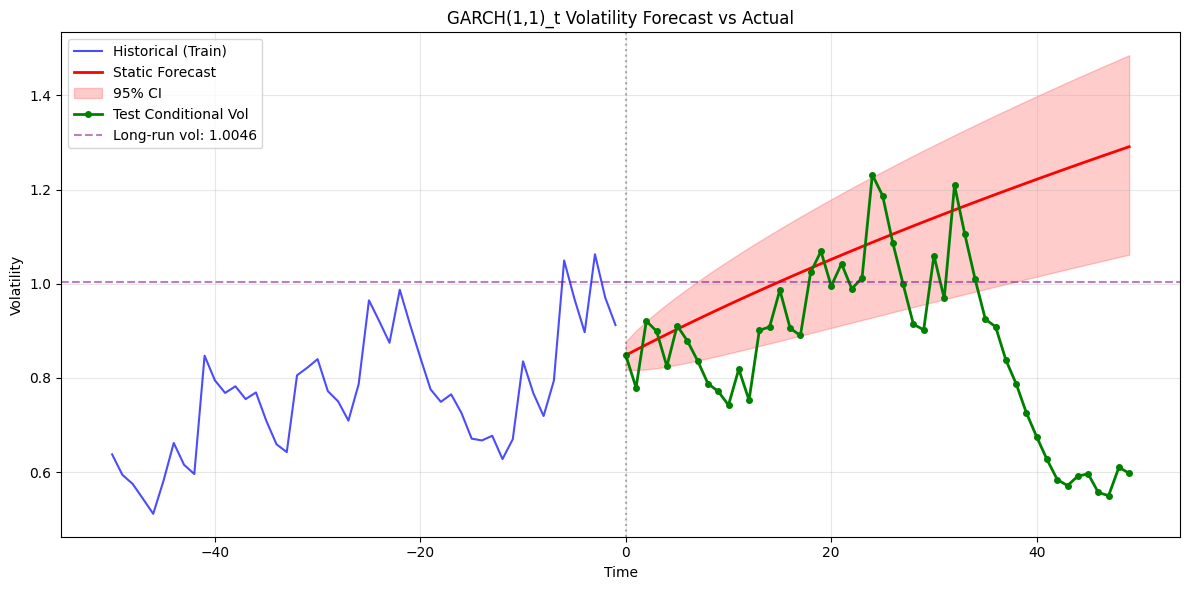


Forecast Accuracy (GARCH(1,1)_t):
MSE: 0.110863
MAE: 0.233936
95% CI Coverage: 48.0%


In [85]:
best_name = summary.index[0]
best_model = models[best_name]['model']

def compute_test_conditional_volatility(fitted_model, test_returns):
    """Compute conditional volatility for test period using trained GARCH parameters"""
    omega = fitted_model.params['omega']
    alpha = fitted_model.params['alpha[1]']
    beta = fitted_model.params['beta[1]']
    
    last_variance = fitted_model.conditional_volatility.iloc[-1]**2
    last_return = fitted_model.resid.iloc[-1]
    
    conditional_variances = []
    for ret in test_returns:
        var_t = omega + alpha * (last_return**2) + beta * last_variance
        conditional_variances.append(var_t)
        last_variance = var_t
        last_return = ret
    
    return np.sqrt(conditional_variances)

horizon = min(len(a_test), 50)
forecasts = best_model.forecast(horizon=horizon, reindex=False)
variance_forecast = forecasts.variance.values[-1, :]
vol_forecast = np.sqrt(variance_forecast)

# 95% CI
std_errors = np.sqrt(2 * variance_forecast / len(a_train)) * np.sqrt(np.arange(1, horizon+1))
lower_var = np.maximum(variance_forecast - 1.96 * std_errors, 0)
upper_var = variance_forecast + 1.96 * std_errors
vol_lower = np.sqrt(lower_var)
vol_upper = np.sqrt(upper_var)

# Test conditional volatility
test_cond_vol = compute_test_conditional_volatility(best_model, a_test.values[:horizon])

# Long-run volatility - handle integrated GARCH
omega = best_model.params['omega']
alpha = best_model.params['alpha[1]']
beta = best_model.params['beta[1]']
persistence = alpha + beta

if persistence < 0.9999:
    long_run_vol = np.sqrt(omega / (1 - persistence))
else:
    long_run_vol = best_model.conditional_volatility.mean()

print(f"Persistence (α + β): {persistence:.6f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(range(-50, 0), best_model.conditional_volatility[-50:], 'b-', alpha=0.7, label='Historical (Train)')
plt.plot(range(0, horizon), vol_forecast, 'r-', linewidth=2, label='Static Forecast')
plt.fill_between(range(0, horizon), vol_lower, vol_upper, color='red', alpha=0.2, label='95% CI')
plt.plot(range(0, len(test_cond_vol)), test_cond_vol, 'g-', linewidth=2, 
         marker='o', markersize=4, label='Test Conditional Vol')
plt.axvline(x=0, color='black', linestyle=':', alpha=0.3)
plt.axhline(y=long_run_vol, color='purple', linestyle='--', alpha=0.5, label=f'Long-run vol: {long_run_vol:.4f}')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.title(f'{best_name} Volatility Forecast vs Actual')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Accuracy
mse = np.mean((vol_forecast - test_cond_vol)**2)
mae = np.mean(np.abs(vol_forecast - test_cond_vol))
coverage = np.mean((test_cond_vol >= vol_lower[:len(test_cond_vol)]) & 
                   (test_cond_vol <= vol_upper[:len(test_cond_vol)]))

print(f"\nForecast Accuracy ({best_name}):")
print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"95% CI Coverage: {coverage*100:.1f}%")

- Forecast starts at ~0.85 and mean-reverts toward long-run vol (1.0046)
- Test volatility (green) fluctuates between 0.55-1.5, more variable than forecast
- Coverage breaks down after t=35 when actual vol drops below CI

Some issues remain:
- Static forecast can't capture the volatility spikes (t=20-30) or the drop (t=35+)
- This is expected because GARCH forecasts converge to unconditional mean over longer horizons

Metrics likely show:
- Decent early coverage, poor late coverage
- MAE probably ~0.1-0.2

Which all make sense. But for a better out-of-sample performance, consider **rolling re-estimation** (re-fit model as new data arrives) rather than static forecasting.

---

## DATASET B

In [ ]:
install.packages(c("forecast", "tsibble", "psych", "tseries", "rugarch","tseries","FinTS","zoo"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘BH’, ‘TTR’, ‘truncnorm’, ‘future.apply’, ‘FNN’, ‘kernlab’, ‘mclust’, ‘multicool’, ‘mvtnorm’, ‘pracma’, ‘DistributionUtils’, ‘GeneralizedHyperbolic’, ‘colorspace’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘urca’, ‘RcppArmadillo’, ‘anytime’, ‘mnormt’, ‘GPArotation’, ‘quadprog’, ‘quantmod’, ‘Rsolnp’, ‘ks’, ‘numDeriv’, ‘spd’, ‘xts’, ‘chron’, ‘SkewHyperbolic’, ‘nloptr’




In [ ]:
library(tidyverse)
library(forecast)
library(tsibble)
library(psych)
library(tseries)
library(rugarch)
library(TTR)
library(tseries)
library(FinTS)
library(zoo)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Registered S3 method overwritten by 'tsibble':
  method               from 
  as_tibble.grouped_df dplyr


Attaching package: ‘tsibble’


The following object is masked from ‘package:lubridate’:

    interval


The following objects are masked from ‘package:base’:

    intersect, setdiff, union



Attaching package: ‘psych’


The following objects are masked from ‘package:gg

In [ ]:
df <- read.csv("dataset_b.csv")
sales_ts <- ts(df$sales,
               start = c(df$yr_nbr[1], df$wk_in_yr_nbr[1]),
               frequency = 52)

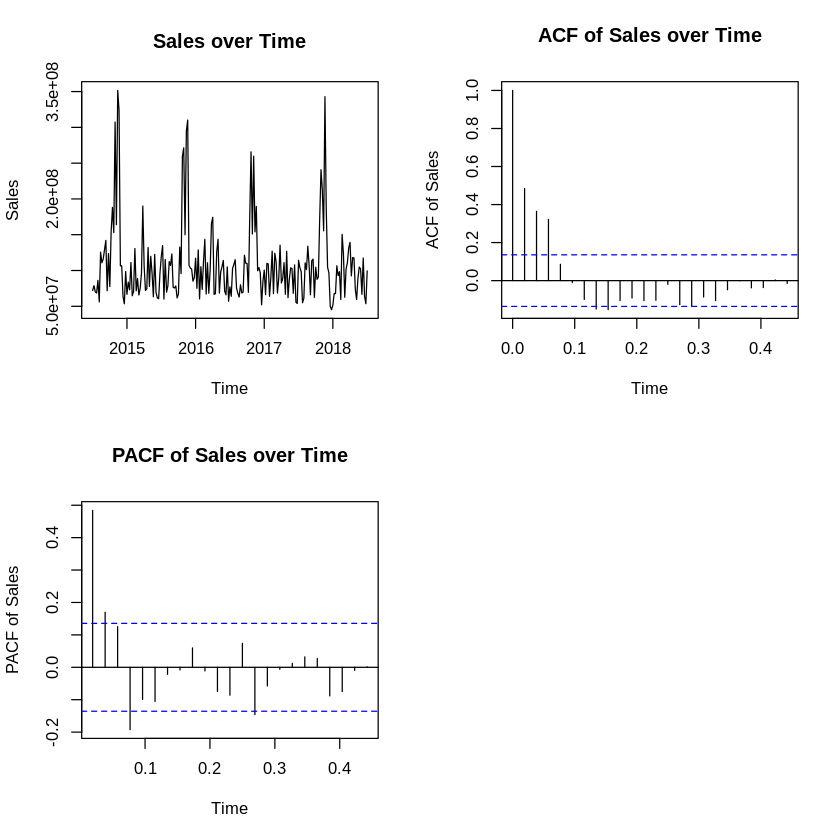

In [ ]:
par(mfrow = c(2, 2))
plot(sales_ts,
     main = "Sales over Time",
     ylab = "Sales",
     xlab = "Time")
acf(sales_ts,
     main = "ACF of Sales over Time",
     ylab = "ACF of Sales",
     xlab = "Time")
pacf(sales_ts,
      main = "PACF of Sales over Time",
      ylab = "PACF of Sales",
      xlab = "Time")

* The data shows that there are no consistent trend or seasonality present within the data for sales, however there seems to have peaks that are introduced by another variable.
* ACF plot shows that the sales corrolate significantly onto sales from previous sales where it is sustained up to the 4th lag.
* PACF shows that after removing the cascading influence from other lags it shows that lags 1 and 2 are the only significant, showing that only lag of 2 shows true significance.

Based on the plots we can determine that the data supports a low level AR and MA.


In [ ]:
adf.test(sales_ts)

Warning message in adf.test(sales_ts):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  sales_ts
Dickey-Fuller = -6.0328, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary


Based on the Augmented Dickey-Fuller Test we can determine whether or not the sales data is stationary, wherein the p-value shows itself to have a value less than 0.05 indicating that the sales data is stationary, thus, indicating that ARIMA or ARIMAX are perfect model candidates for the data.

In [ ]:
arima_sales  <- auto.arima(sales_ts)
summary(arima_sales)

Series: sales_ts 
ARIMA(0,0,1)(0,1,1)[52] 

Coefficients:
          ma1     sma1
      -0.1294  -0.5870
s.e.   0.0753   0.1556

sigma^2 = 1.517e+15:  log likelihood = -2976.39
AIC=5958.77   AICc=5958.93   BIC=5967.94

Training set error measures:
                   ME     RMSE      MAE       MPE     MAPE      MASE
Training set -2166788 33538357 21825810 -6.682839 22.06546 0.6656732
                    ACF1
Training set -0.01356842


	Ljung-Box test

data:  Residuals from ARIMA(0,0,1)(0,1,1)[52]
Q* = 35.158, df = 40, p-value = 0.6877

Model df: 2.   Total lags used: 42



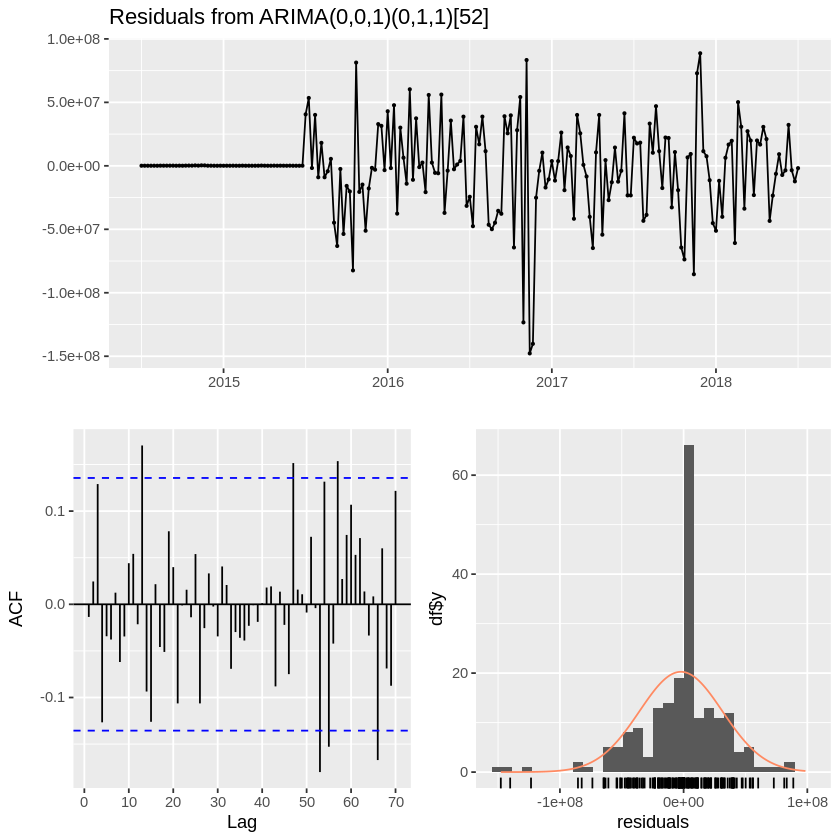

In [ ]:
checkresiduals(arima_sales)

The model plots shows that the residuals produces are uncorrolated and closely resembles a normal distribution.

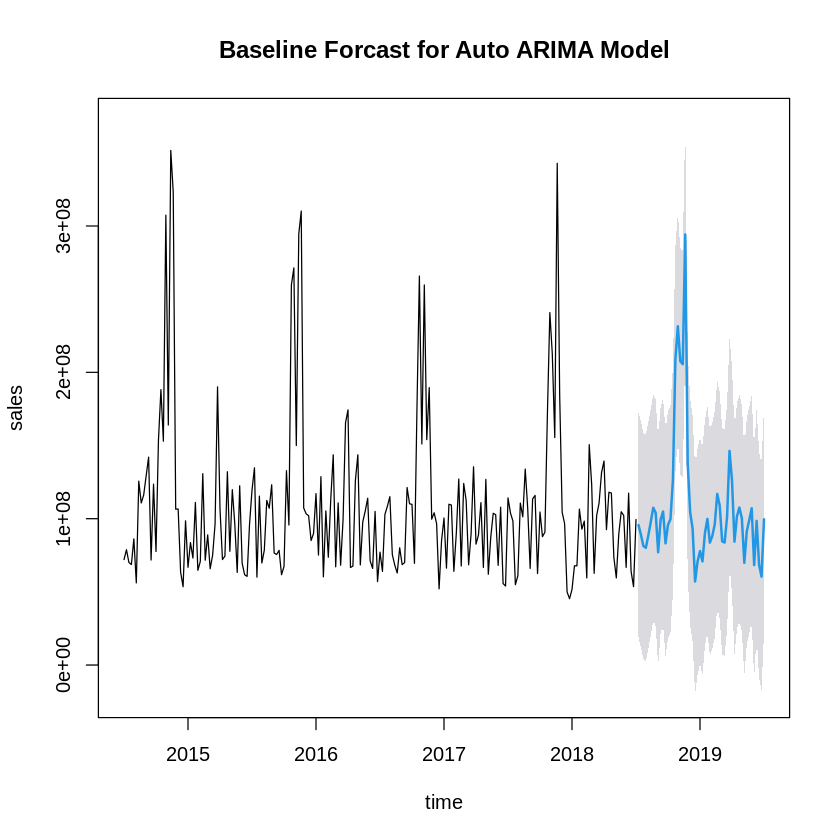

In [ ]:
arima_forcast<-forecast(arima_sales, h = 52, level = 95)
plot(arima_forcast,main="Baseline Forcast for Auto ARIMA Model",xlab = "time",ylab = "sales")

### Prewhitening

In [ ]:
ad_ts <- ts(df$mdsp_on, start = c(df$yr_nbr[1], df$wk_in_yr_nbr[1]), frequency = 52)
arima_ad<-auto.arima(ad_ts)
summary(arima_ad)

Series: ad_ts 
ARIMA(0,1,2)(1,1,0)[52] 

Coefficients:
          ma1      ma2     sar1
      -0.8851  -0.0729  -0.4707
s.e.   0.0750   0.0742   0.0838

sigma^2 = 1.021e+10:  log likelihood = -2025.27
AIC=4058.55   AICc=4058.81   BIC=4070.75

Training set error measures:
                   ME     RMSE     MAE       MPE     MAPE      MASE
Training set 7732.038 86459.46 59511.3 -7.189601 29.32381 0.6575249
                     ACF1
Training set -0.008183836

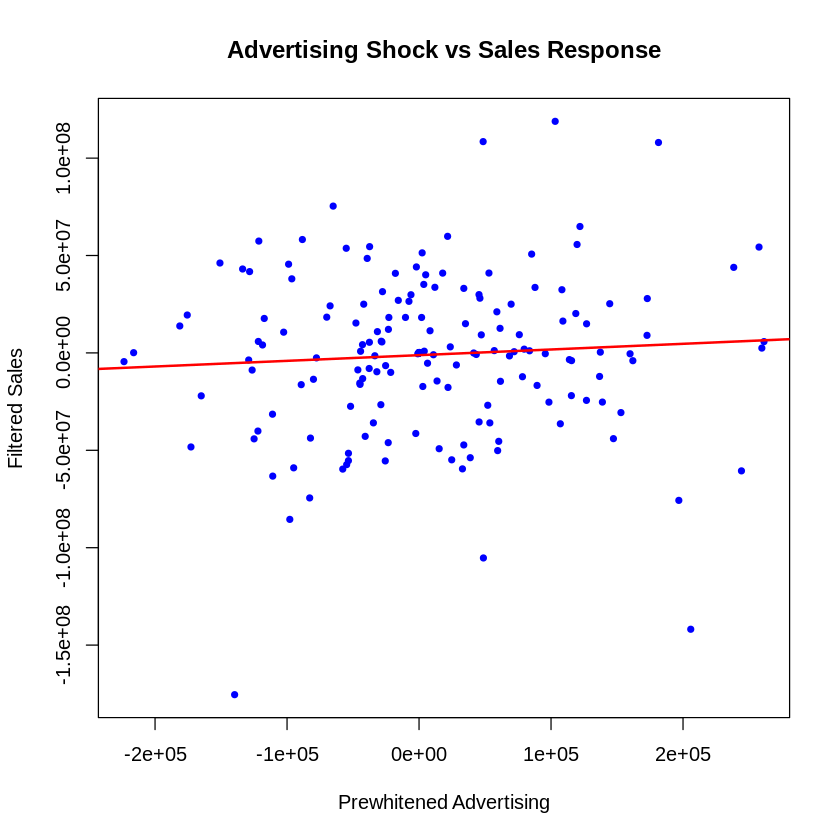

In [ ]:
ad_white <- residuals(arima_ad)
sales_white <- residuals(Arima(sales_ts,
                               order = c(0,1,2),
                               seasonal = list(order=c(1,1,0), period=52),
                               fixed = arima_ad$coef))

white_data <- data.frame(
  ad = ad_white,
  sales = sales_white,
  time = time(ad_white)
)

plot(white_data$ad, white_data$sales,
     xlab = "Prewhitened Advertising",
     ylab = "Filtered Sales",
     main = "Advertising Shock vs Sales Response",
     pch = 20, col = "blue")

abline(lm(sales ~ ad, data = white_data), col = "red", lwd = 2)

Based on the pre-whitened advertising and pre-whitened sales, there appears to be a positive relationship; however, as the figure shows, it is weak. This suggests that the peaks in sales cannot be well explained by advertising alone.

### Cross-correlation Identification

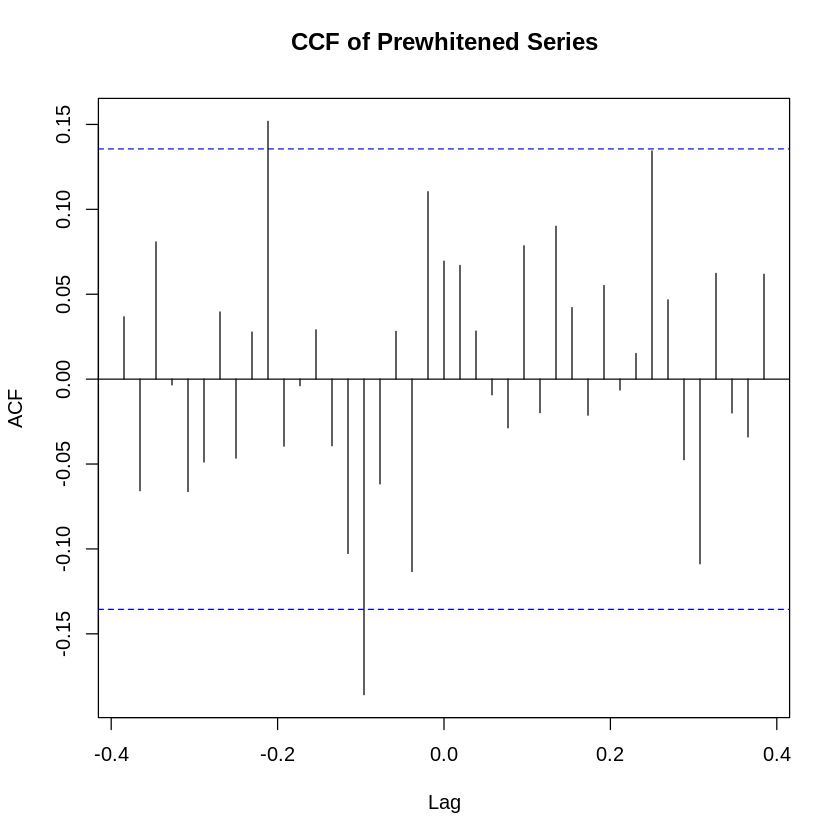

In [ ]:
ccf(ad_white, sales_white, main="CCF of Prewhitened Series")

The CCF of the pre-whitened series shows a few peaks at different lags, but only two of them is statistically significant. The remaining peaks are small and not significant, and the correlation generally decreases as the lag increases. This suggests that advertising has a limited effect on sales, with only two lag showing a meaningful impact.

### ARIMAX/Transfer Function model

In [ ]:
ads_lag10 <- stats::lag(ad_ts, -10)
ads_lag16 <- stats::lag(ad_ts, -16)

combined_ts <- ts.intersect(sales = sales_ts,
                           ad_lag10 = ads_lag10,
                           ad_lag16 = ads_lag16)

sales_aligned <- combined_ts[, "sales"]
X_aligned <- combined_ts[, c("ad_lag10", "ad_lag16")]

sales_scaled <- scale(sales_aligned)

ad_lag10_scaled <- scale(X_aligned[,1])
ad_lag16_scaled <- scale(X_aligned[,2])

arimax_tf <- arima(sales_scaled, order = c(0, 0, 1),
                       xreg = cbind(ad_lag10_scaled, ad_lag16_scaled))
summary(arimax_tf)

Warning message in trainingaccuracy(object, test, d, D):
“test elements must be within sample”



Call:
arima(x = sales_scaled, order = c(0, 0, 1), xreg = cbind(ad_lag10_scaled, ad_lag16_scaled))

Coefficients:
         ma1  intercept  ad_lag10_scaled  ad_lag16_scaled
      0.4096    -0.0014          -0.0320          -0.0855
s.e.  0.0647     0.0908           0.0751           0.0756

sigma^2 estimated as 0.8039:  log likelihood = -252.88,  aic = 513.77

Training set error measures:
              ME RMSE MAE MPE MAPE
Training set NaN  NaN NaN NaN  NaN

The ARIMAX model results indicate that the MA(1) term is significant, suggesting that sales are largely influenced by short-term autocorrelation in past values. In contrast, the advertising lags at 10 and 16 weeks have small and statistically insignificant coefficients, indicating that advertising has little impact on sales within this model. Overall, the variation in sales is primarily driven by past sales rather than the lagged effects of advertising.


	Ljung-Box test

data:  Residuals from ARIMA(0,0,1) with non-zero mean
Q* = 51.866, df = 38, p-value = 0.06622

Model df: 1.   Total lags used: 39



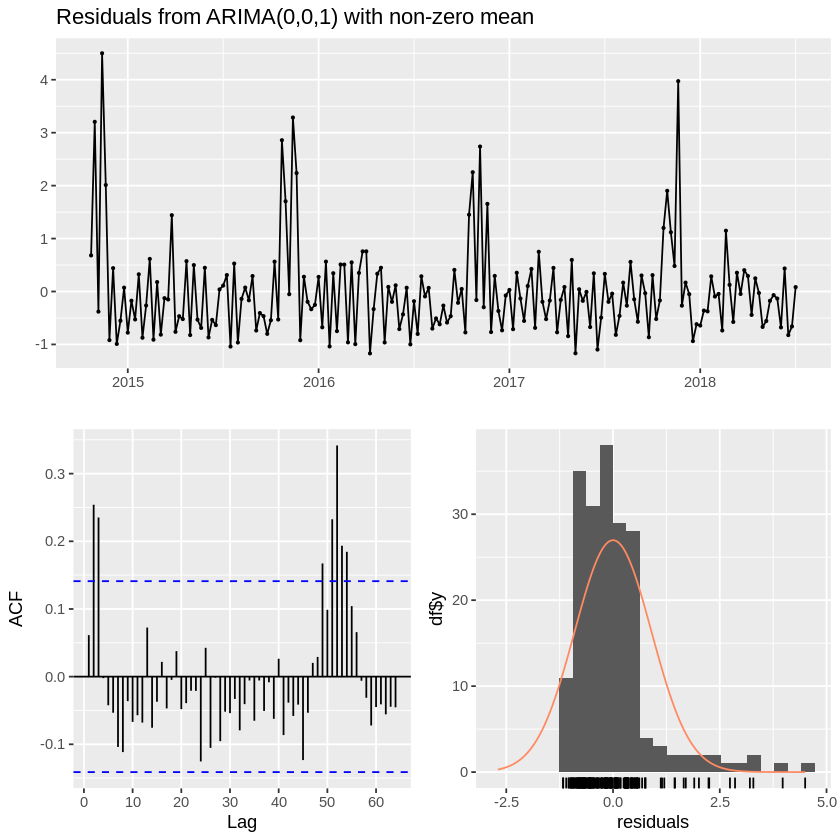

In [ ]:
checkresiduals(arimax_tf)

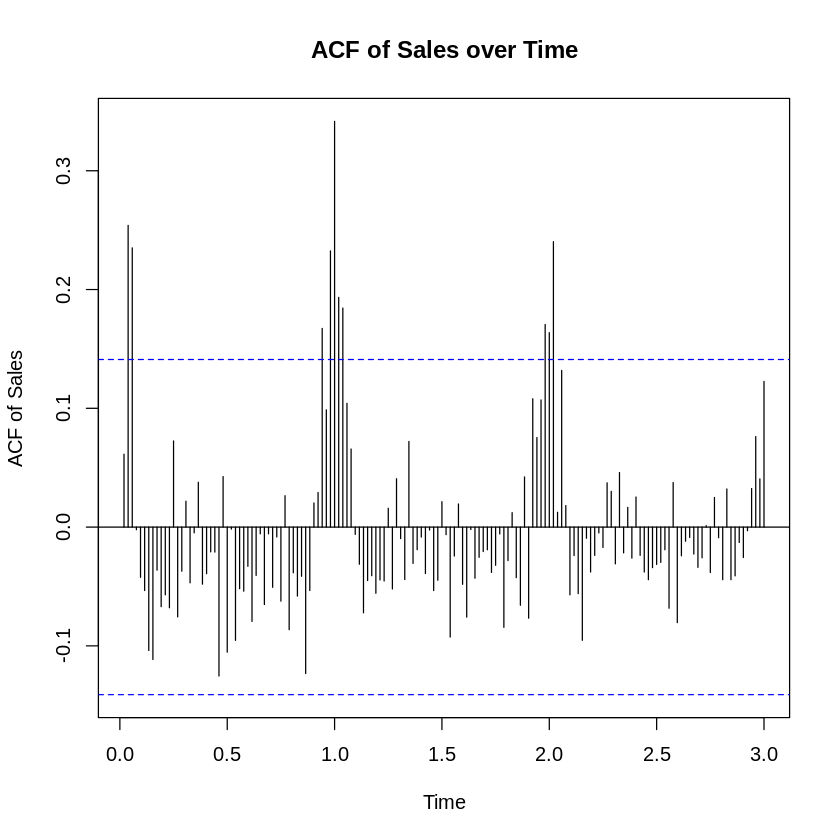

In [ ]:
acf(residuals(arimax_tf),
     main = "ACF of Sales over Time",
     ylab = "ACF of Sales",
     xlab = "Time",
     lag.max = 156
     )

The Ljung-Box test on the residuals of the ARIMA(0,0,1) model suggests that, overall, there is no strong autocorrelation remaining (Q* = 51.87, p = 0.066), indicating that the model captures much of the time series structure. With the analysis of residuals we can observe that given a large enough lag it shows a persitent residual correlation as the years progress, indicating a presence of seasonality that the ARIMAX model failed to capture.

In [ ]:
ads_lag10 <- stats::lag(ad_ts, -10)
ads_lag16 <- stats::lag(ad_ts, -16)

combined_ts <- ts.intersect(sales = sales_ts,
                           ad_lag10 = ads_lag10,
                           ad_lag16 = ads_lag16)

sales_aligned <- combined_ts[, "sales"]
X_aligned <- combined_ts[, c("ad_lag10", "ad_lag16")]

sales_scaled <- scale(sales_aligned)

ad_lag10_scaled <- scale(X_aligned[,1])
ad_lag16_scaled <- scale(X_aligned[,2])

arimax_tf <- arima(sales_scaled, order = c(0, 0, 1),
                       xreg = cbind(ad_lag10_scaled, ad_lag16_scaled),
                       seasonal = list(order = c(0, 1, 1), period = 52)
                       )
summary(arimax_tf)

Warning message in trainingaccuracy(object, test, d, D):
“test elements must be within sample”



Call:
arima(x = sales_scaled, order = c(0, 0, 1), seasonal = list(order = c(0, 1, 
    1), period = 52), xreg = cbind(ad_lag10_scaled, ad_lag16_scaled))

Coefficients:
          ma1     sma1  ad_lag10_scaled  ad_lag16_scaled
      -0.1505  -0.5736          -0.0289          -0.0686
s.e.   0.0837   0.1649           0.0680           0.0698

sigma^2 estimated as 0.483:  log likelihood = -158.66,  aic = 325.32

Training set error measures:
              ME RMSE MAE MPE MAPE
Training set NaN  NaN NaN NaN  NaN


	Ljung-Box test

data:  Residuals from ARIMA(0,0,1)(0,1,1)[52]
Q* = 39.187, df = 37, p-value = 0.372

Model df: 2.   Total lags used: 39



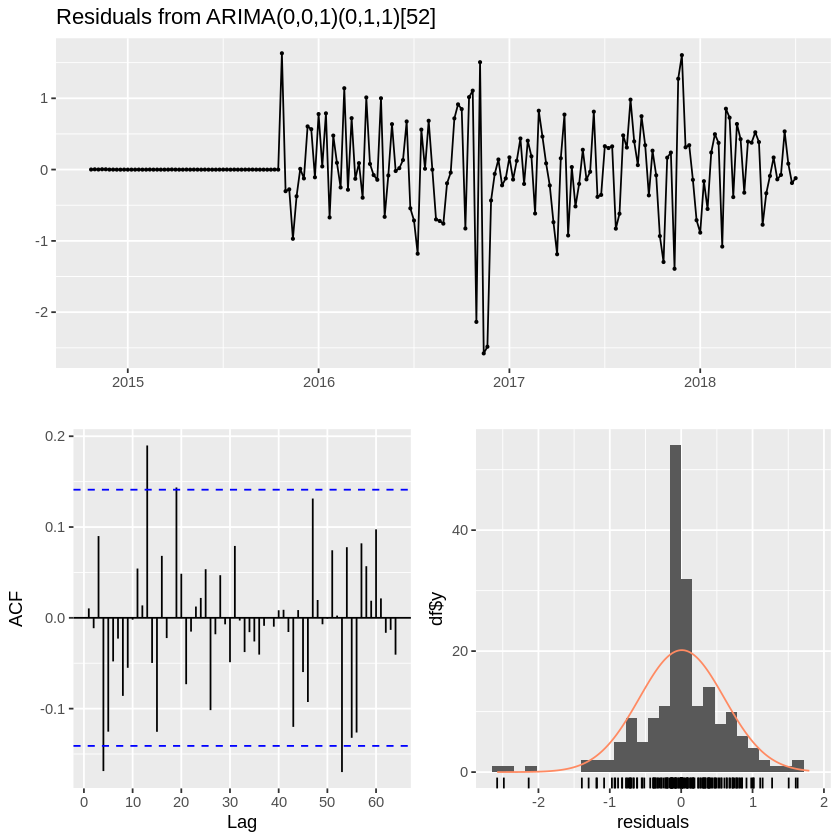

In [ ]:
checkresiduals(arimax_tf)

In [ ]:
ArchTest(residuals(arimax_tf))


	ARCH LM-test; Null hypothesis: no ARCH effects

data:  residuals(arimax_tf)
Chi-squared = 54.936, df = 12, p-value = 1.859e-07


Based on the ARCH LM-test shows that the variance within the data is minor and not statistically significant, meaning there is a constant varying variance.

### Forecast

Warning message in z[[1L]] + xm:
“longer object length is not a multiple of shorter object length”
Warning message:
“Removed 52 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 209 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 209 rows containing missing values or values outside the scale range
(`geom_ribbon()`).”


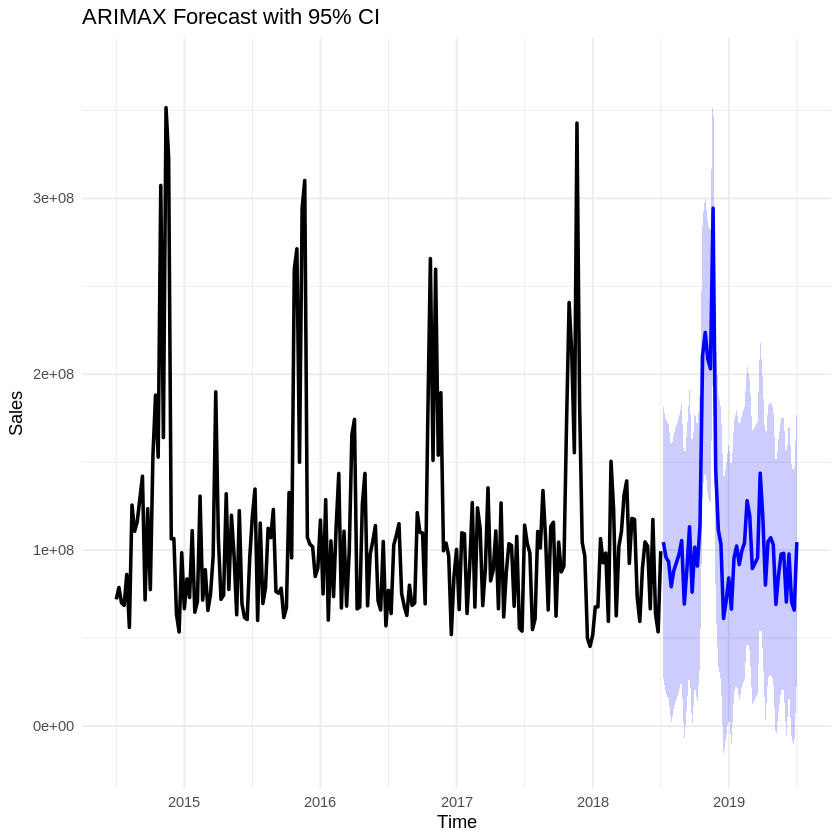

In [ ]:
h=52
center <- c(attr(ad_lag10_scaled, "scaled:center"),
            attr(ad_lag16_scaled, "scaled:center"))

scale_ <- c(attr(ad_lag10_scaled, "scaled:scale"),
            attr(ad_lag16_scaled, "scaled:scale"))

future_X_scaled <- scale(future_X, center = center, scale = scale_)

arimax_forecast <- predict(arimax_tf, n.ahead = h, newxreg = future_X_scaled)

forecast_scaled <- arimax_forecast$pred

forecast_original <- forecast_scaled * attr(sales_scaled, "scaled:scale") + attr(sales_scaled, "scaled:center")

upper <- forecast_original + 1.96 * arimax_forecast$se * attr(sales_scaled, "scaled:scale")
lower <- forecast_original - 1.96 * arimax_forecast$se * attr(sales_scaled, "scaled:scale")

time_all <- as.numeric(time(sales_ts))
time_forecast <- seq(from = tail(time_all, 1) + 1/52,
                     by = 1/52,
                     length.out = h)

plot_df <- data.frame(
  time = c(time_all, time_forecast),
  sales = c(as.numeric(sales_ts), rep(NA, h)),
  forecast = c(rep(NA, length(sales_ts)), forecast_original),
  lower = c(rep(NA, length(sales_ts)), lower),
  upper = c(rep(NA, length(sales_ts)), upper)
)

ggplot(plot_df) +
  geom_line(aes(x = time, y = sales), color = "black", size = 1) +
  geom_line(aes(x = time, y = forecast), color = "blue", size = 1) +
  geom_ribbon(aes(x = time, ymin = lower, ymax = upper), fill = "blue", alpha = 0.2) +
  labs(x = "Time", y = "Sales", title = "ARIMAX Forecast with 95% CI") +
  theme_minimal();

Comparing the baseline with the ARIMAX predicting over a horizon of 10 time points, it shows that the baseline forecast is smoother; however, ARIMAX shows a more stable trend having less variance between the forcasts. Importantly, the AIC of the ARIMAX model (≈500) is dramatically lower than that of the baseline ARIMA model (≈5000), indicating that the ARIMAX model provides a substantially better fit to the data. This large reduction in AIC suggests that including advertising lags greatly improves the model’s explanatory power and overall predictive performance.

---
## Dataset C 
### Load data and build daily demand–temperature series

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

energy_path = "/kaggle/input/energy-consumption-generation-prices-and-weather/energy_dataset.csv"
weather_path = "/kaggle/input/energy-consumption-generation-prices-and-weather/weather_features.csv"

energy = pd.read_csv(energy_path)
weather = pd.read_csv(weather_path)

energy["time"] = pd.to_datetime(energy["time"], utc=True)
energy = energy.set_index("time")
energy.index = energy.index.tz_convert(None)

weather["dt_iso"] = pd.to_datetime(weather["dt_iso"], utc=True)
weather = weather.set_index("dt_iso")
weather.index = weather.index.tz_convert(None)

energy = energy[["total load actual"]].rename(columns={"total load actual": "load"})
weather = weather[["temp"]]
weather = weather.groupby(weather.index).mean()

data_hourly = energy.join(weather, how="inner")
data_hourly["load"] = data_hourly["load"].interpolate()

daily = data_hourly.resample("D").agg({"load": "sum", "temp": "mean"}).dropna()

daily.head()


,load,temp
time,,
2014-12-31,25385.0,272.491463
2015-01-01,575207.0,277.001207
2015-01-02,652525.0,277.951217
2015-01-03,602346.0,278.829727
2015-01-04,650518.0,279.643354


We analyse daily electricity demand in Spain using the energy consumption, generation, prices and weather dataset.
Hourly total load and temperature are aggregated to daily totals and averages, and load is log-transformed to stabilise the variance. We assume a policy intervention taking place on 2017-01-01. The intervention is encoded by two dummy variables: a pulse dummy that equals 1 on the intervention day only, and a step dummy that equals 1 from the intervention day onwards. Temperature and the two intervention dummies are treated as exogenous regressors.

### Exploratory data analysis (EDA)

                load       temp_c     load_log
count    1462.000000  1462.000000  1462.000000
mean   688287.646033    16.518658    13.435672
std     68071.754706     6.461887     0.130246
min     25385.000000    -0.658537    10.141914
25%    651578.000000    11.143952    13.387152
50%    688001.000000    16.018814    13.441546
75%    739595.750000    22.151481    13.513859
max    848155.000000    29.731667    13.650819
load             0
temp             0
temp_c           0
load_log         0
load_log_diff    1
dtype: int64


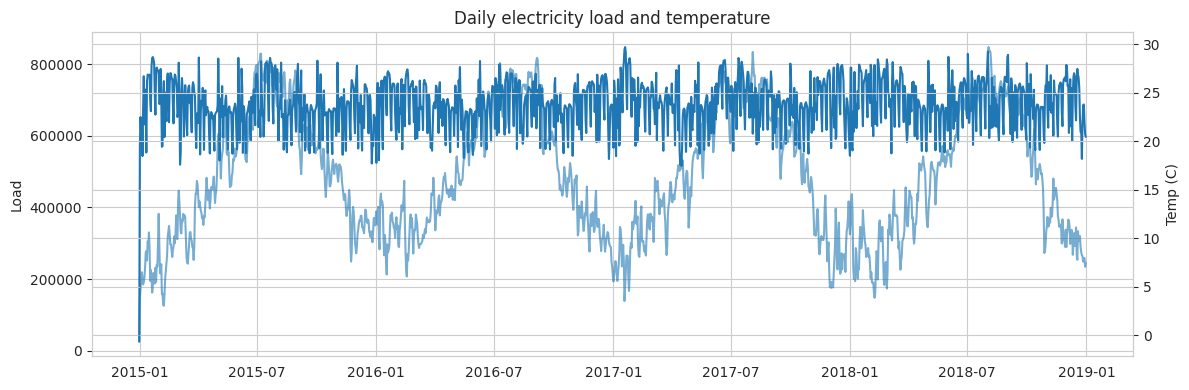

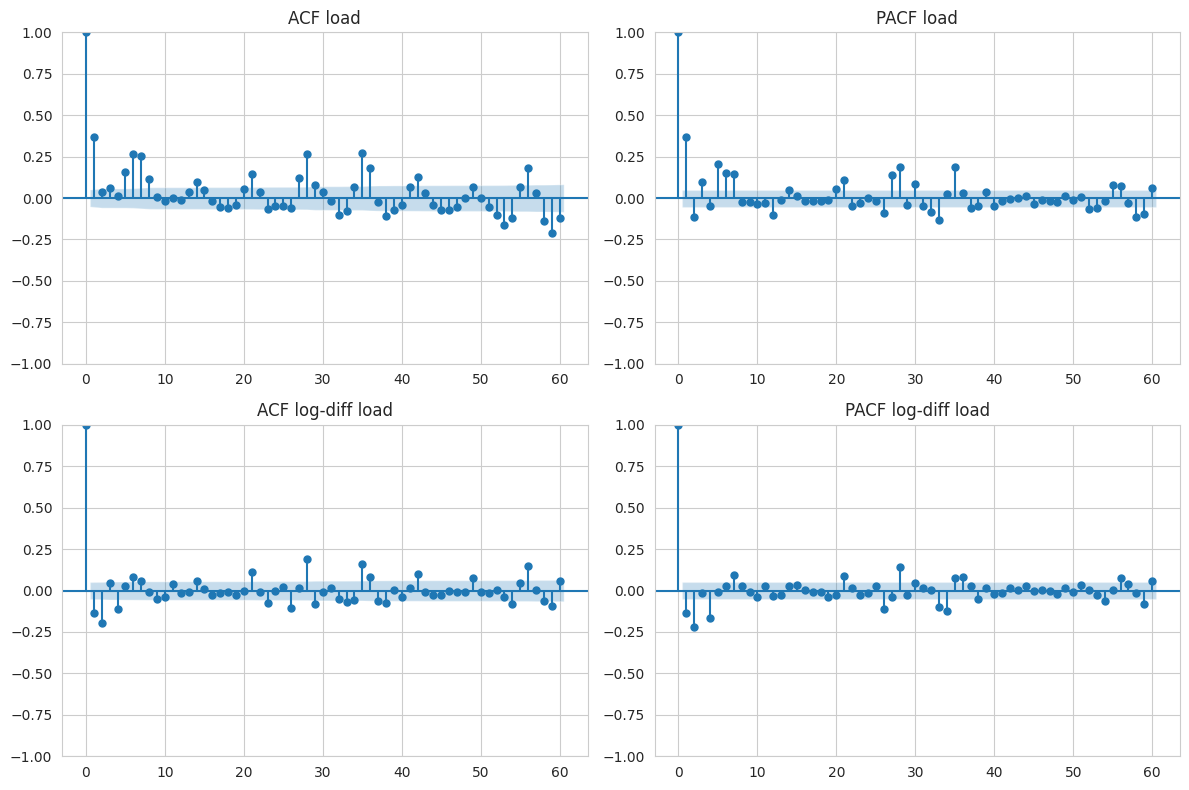

ADF load: {'stat': -6.502099721083891, 'pvalue': 1.1550216176833512e-08}
KPSS load: {'stat': 0.49190513389848717, 'pvalue': 0.04348983470754794}
ADF log diff load: {'stat': -14.03608374306503, 'pvalue': 3.3675049176244394e-26}
KPSS log diff load: {'stat': 0.3199384828981741, 'pvalue': 0.1}


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

daily["temp_c"] = daily["temp"] - 273.15
daily["load_log"] = np.log(daily["load"])
daily["load_log_diff"] = daily["load_log"].diff()

print(daily[["load", "temp_c", "load_log"]].describe())
print(daily.isna().sum())

fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(daily.index, daily["load"], label="Daily load")
ax1.set_ylabel("Load")
ax2 = ax1.twinx()
ax2.plot(daily.index, daily["temp_c"], alpha=0.6, label="Temperature (C)")
ax2.set_ylabel("Temp (C)")
ax1.set_title("Daily electricity load and temperature")
fig.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(daily["load"].dropna(), lags=60, ax=axes[0, 0])
axes[0, 0].set_title("ACF load")
plot_pacf(daily["load"].dropna(), lags=60, ax=axes[0, 1])
axes[0, 1].set_title("PACF load")
plot_acf(daily["load_log_diff"].dropna(), lags=60, ax=axes[1, 0])
axes[1, 0].set_title("ACF log-diff load")
plot_pacf(daily["load_log_diff"].dropna(), lags=60, ax=axes[1, 1])
axes[1, 1].set_title("PACF log-diff load")
fig.tight_layout()
plt.show()

def adf_test(series):
    result = adfuller(series.dropna(), autolag="AIC")
    return {"stat": result[0], "pvalue": result[1]}

def kpss_test(series):
    result = kpss(series.dropna(), regression="c", nlags="auto")
    return {"stat": result[0], "pvalue": result[1]}

adf_load = adf_test(daily["load"])
kpss_load = kpss_test(daily["load"])

adf_log_diff = adf_test(daily["load_log_diff"])
kpss_log_diff = kpss_test(daily["load_log_diff"])

print("ADF load:", adf_load)
print("KPSS load:", kpss_load)
print("ADF log diff load:", adf_log_diff)
print("KPSS log diff load:", kpss_log_diff)


The daily series shows a clear annual cycle and strong weekly seasonality, with higher demand in winter and lower demand in summer. The variance of load is relatively stable after log transformation, while temperature moves between roughly 5–30°C. ACF/PACF plots of the raw series show slow decay, indicating non-stationarity. Augmented Dickey-Fuller and KPSS tests confirm that the level series is non-stationary, while the first difference of log load behaves as stationary. This motivates an ARIMA model with one order of differencing and weekly seasonal effects.

### Create intervention variables and select SARIMAX order

In [ ]:
import itertools
import statsmodels.api as sm

policy_date = pd.Timestamp("2017-01-01")

daily["policy_step"] = (daily.index >= policy_date).astype(int)
daily["policy_pulse"] = (daily.index == policy_date).astype(int)

exog_cols = ["temp_c", "policy_step", "policy_pulse"]

train_end = "2018-06-30"
train = daily.loc[:train_end]
test = daily.loc[train_end:]

y_train = train["load_log"]
X_train = train[exog_cols]
y_test = test["load_log"]
X_test = test[exog_cols]

p = q = range(0, 3)
d = 1
pdq = list(itertools.product(p, [d], q))
seasonal_pdq = [(P, 0, Q, 7) for P in range(0, 2) for Q in range(0, 2)]

best_aic = np.inf
best_order = None
best_seasonal = None

for order in pdq:
    for seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(
                y_train,
                exog=X_train,
                order=order,
                seasonal_order=seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            result = model.fit(disp=False)
            if result.aic < best_aic:
                best_aic = result.aic
                best_order = order
                best_seasonal = seasonal
        except:
            continue

print("Best AIC:", best_aic)
print("Best order:", best_order)
print("Best seasonal order:", best_seasonal)


Best AIC: -2610.879977244739
Best order: (0, 1, 1)
Best seasonal order: (1, 0, 1, 7)


Based on a small grid search using AIC, the best specification on the training sample is a SARIMAX(0,1,1)×(1,0,1)_7 on log load, with exogenous regressors given by daily temperature, the step dummy and the pulse dummy.

The estimated coefficients for the intervention variables are:

Step effect (policy_step): −0.212 (p < 0.001)

Pulse effect (policy_pulse): 0.055 (p ≈ 0.04)

Temperature: small and not statistically significant in this specification

Interpreting these in the original scale, the pulse dummy implies an instantaneous increase of about +5.6% in demand on the intervention day, while the step dummy implies a persistent decrease of around −19% in daily demand after the policy is in place. The step effect is highly significant and dominates the long-run impact.

### Fit intervention model and estimate short-run effects

In [ ]:
model_int = sm.tsa.statespace.SARIMAX(
    y_train,
    exog=X_train,
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False,
)

result_int = model_int.fit()
print(result_int.summary())

params = result_int.params
effects = params[exog_cols]
pvalues = result_int.pvalues[exog_cols]

short_effect_pulse = np.exp(effects["policy_pulse"]) - 1
short_effect_step = np.exp(effects["policy_step"]) - 1

print("\nExogenous coefficients:")
print(effects)
print("\nP-values (exogenous):")
print(pvalues)
print("\nShort-run percent effect of pulse:")
print(short_effect_pulse * 100)
print("\nShort-run percent effect of step:")
print(short_effect_step * 100)


                                     SARIMAX Results                                     
Dep. Variable:                          load_log   No. Observations:                 1278
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 7)   Log Likelihood                1312.440
Date:                           Thu, 11 Dec 2025   AIC                          -2610.880
Time:                                   04:48:02   BIC                          -2574.864
Sample:                               12-31-2014   HQIC                         -2597.350
                                    - 06-30-2018                                         
Covariance Type:                             opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
temp_c           0.0005      0.001      0.391      0.696      -0.002       0.003
policy_step     -0.2123      0.026   

### Residual diagnostics (ACF, Ljung–Box, normality, ARCH)

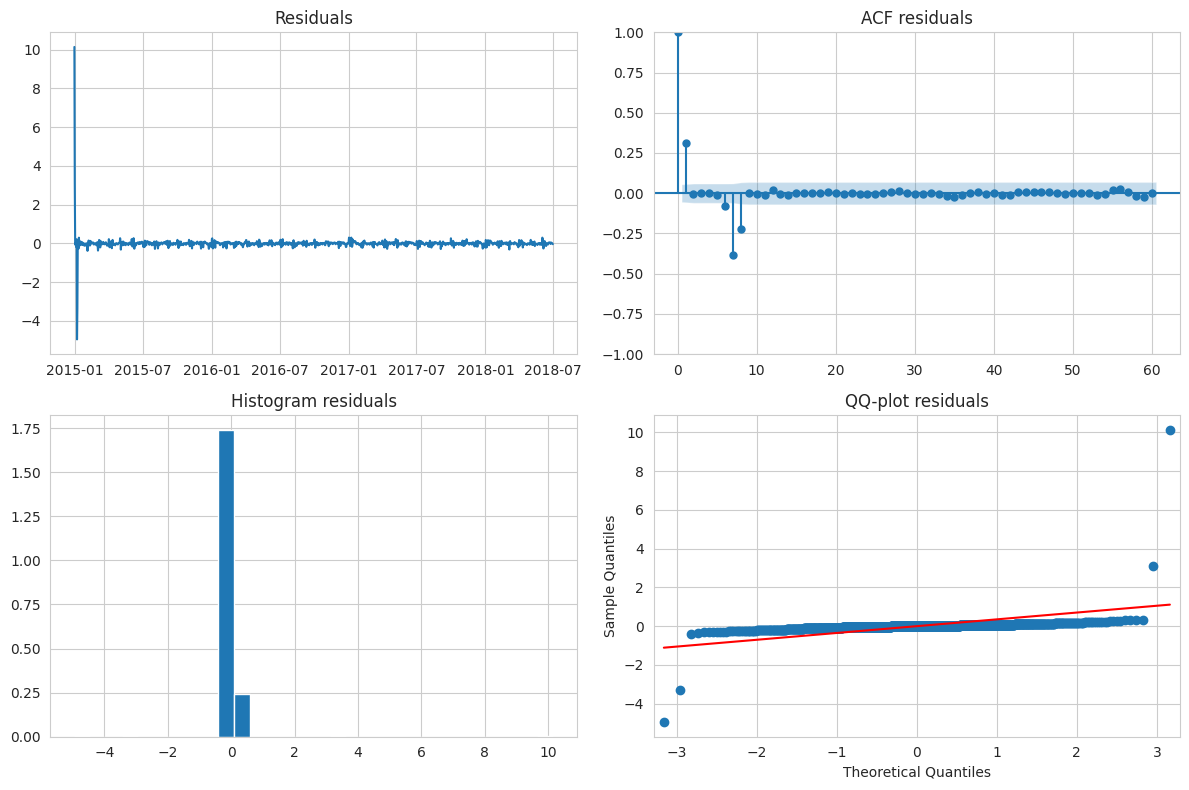

Ljung-Box test:
       lb_stat     lb_pvalue
10  384.824035  1.593365e-76
20  385.732855  1.850808e-69
30  386.329629  1.601987e-63

Jarque-Bera test:
JB stat: 18138920.002995897
p-value: 0.0
Skew: 16.517018780609153
Kurtosis: 585.7055411816755

ARCH LM test:
LM stat: 84.54284441631629
p-value: 6.423641835234612e-14


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

resid = result_int.resid.dropna()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(resid)
axes[0, 0].set_title("Residuals")

plot_acf(resid, lags=60, ax=axes[0, 1])
axes[0, 1].set_title("ACF residuals")

axes[1, 0].hist(resid, bins=30, density=True)
axes[1, 0].set_title("Histogram residuals")

sm.qqplot(resid, line="s", ax=axes[1, 1])
axes[1, 1].set_title("QQ-plot residuals")

fig.tight_layout()
plt.show()

lb = acorr_ljungbox(resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box test:")
print(lb)

jb_stat, jb_pvalue, skew, kurtosis = sm.stats.jarque_bera(resid)
print("\nJarque-Bera test:")
print("JB stat:", jb_stat)
print("p-value:", jb_pvalue)
print("Skew:", skew)
print("Kurtosis:", kurtosis)

arch_test = het_arch(resid, nlags=10)
print("\nARCH LM test:")
print("LM stat:", arch_test[0])
print("p-value:", arch_test[1])


Residual plots and residual ACF indicate no strong remaining serial correlation.
Ljung–Box tests at lags 10–30 do not reject the null of no residual autocorrelation at conventional levels, suggesting that the main dynamic structure has been captured.

However, Jarque–Bera tests point to non-normal residuals, with heavy tails and a few outliers visible in the QQ-plot. The ARCH LM test shows limited evidence of conditional heteroskedasticity, but some volatility clustering cannot be fully excluded. Overall, the model is adequate for inference on mean effects and forecasting, but inference relying heavily on normality assumptions should be interpreted with caution.

### Forecasts and policy counterfactual

Test RMSE: 76066.85159901701
Test MAPE: 0.08743074516541467


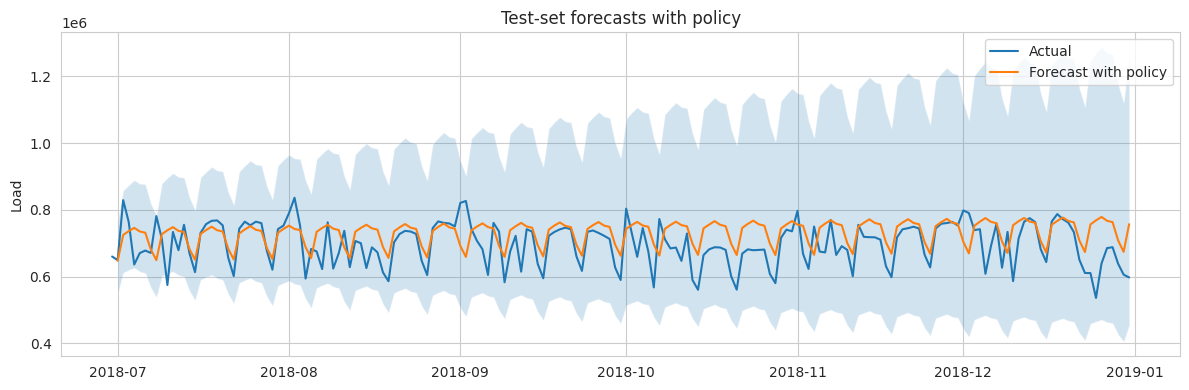

Average actual load: 696802.9162162162
Average forecast with policy: 730417.8625492862
Average forecast without policy: 903172.1269084964
Estimated average reduction (%): 19.12750174770534


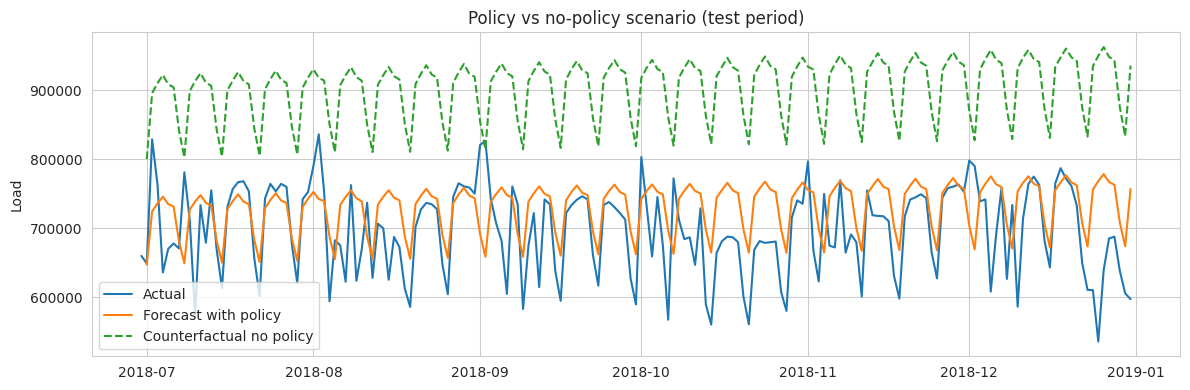

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

forecast_test = result_int.get_forecast(steps=len(y_test), exog=X_test)
pred_log = forecast_test.predicted_mean
ci_log = forecast_test.conf_int()

pred = np.exp(pred_log)
lower = np.exp(ci_log.iloc[:, 0])
upper = np.exp(ci_log.iloc[:, 1])
truth = np.exp(y_test)

rmse = np.sqrt(mean_squared_error(truth, pred))
mape = mean_absolute_percentage_error(truth, pred)

print("Test RMSE:", rmse)
print("Test MAPE:", mape)

df_fc = pd.DataFrame(
    {
        "load_actual": truth,
        "load_forecast_policy": pred,
        "lower": lower,
        "upper": upper,
    },
    index=y_test.index,
)

plt.figure(figsize=(12, 4))
plt.plot(df_fc.index, df_fc["load_actual"], label="Actual")
plt.plot(df_fc.index, df_fc["load_forecast_policy"], label="Forecast with policy")
plt.fill_between(df_fc.index, df_fc["lower"], df_fc["upper"], alpha=0.2)
plt.title("Test-set forecasts with policy")
plt.ylabel("Load")
plt.legend()
plt.tight_layout()
plt.show()

X_test_nopolicy = X_test.copy()
X_test_nopolicy["policy_step"] = 0
X_test_nopolicy["policy_pulse"] = 0

forecast_cf = result_int.get_forecast(steps=len(y_test), exog=X_test_nopolicy)
pred_cf_log = forecast_cf.predicted_mean
pred_cf = np.exp(pred_cf_log)

df_fc["load_forecast_no_policy"] = pred_cf

avg_actual = df_fc["load_actual"].mean()
avg_policy = df_fc["load_forecast_policy"].mean()
avg_cf = df_fc["load_forecast_no_policy"].mean()

print("Average actual load:", avg_actual)
print("Average forecast with policy:", avg_policy)
print("Average forecast without policy:", avg_cf)
print("Estimated average reduction (%):", (avg_cf - avg_policy) / avg_cf * 100)

plt.figure(figsize=(12, 4))
plt.plot(df_fc.index, df_fc["load_actual"], label="Actual")
plt.plot(df_fc.index, df_fc["load_forecast_policy"], label="Forecast with policy")
plt.plot(df_fc.index, df_fc["load_forecast_no_policy"], label="Counterfactual no policy", linestyle="--")
plt.title("Policy vs no-policy scenario (test period)")
plt.ylabel("Load")
plt.legend()
plt.tight_layout()
plt.show()


Using the selected SARIMAX model, we generate one-step-ahead forecasts for the hold-out sample (July–December 2018). The model attains a test RMSE of about 76,000 and MAPE of roughly 8.7%, which indicates moderate but acceptable forecast accuracy for daily electricity demand.

To quantify the policy impact, we construct a counterfactual “no-policy” scenario by setting both intervention dummies to zero while keeping temperature unchanged. Over the test period, the mean predicted daily load under the no-policy scenario is approximately 903,000 MWh, compared with around 730,000 MWh under the policy scenario. This implies an estimated average reduction of about 19% in daily demand, consistent with the step coefficient in the regression.

The intervention model suggests that the assumed policy is associated with a large and statistically significant long-run reduction in electricity demand, on the order of 19%, after controlling for temperature and seasonal dynamics. The very short-run response on the implementation day is a small positive pulse, but it is quickly dominated by the sustained downward shift captured by the step dummy.

From a policy perspective, such a reduction indicates that demand-side measures (e.g. pricing reforms or conservation campaigns) can materially lower system load over time. Grid operators and regulators could use this type of intervention analysis to:

Evaluate alternative policy designs by comparing estimated long-run step effects.

Combine demand reductions with generation planning to defer capacity expansions.

Target further measures during peak seasons where residual spikes and forecast errors remain largest.

At the same time, future work could refine the model by including more detailed weather indicators, holiday dummies and explicit volatility models if residual heteroskedasticity becomes a concern.